# Setup

In [1]:
import os
import random
from dataclasses import dataclass
from tqdm import tqdm

import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from PIL import Image
from torchvision.transforms import ToTensor
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import get_cosine_schedule_with_warmup
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )    
import wandb
import matplotlib.pyplot as plt

from data.datasets.inverse_web_dataset import get_dataset
from instructflow.utils import show_images, seed_everything   
from instructflow.data.transforms import JPEGCompression, DownScale, Noising, GaussinaBlur, Grayscale

In [2]:
import yaml
from omegaconf import OmegaConf
import tempfile


with open("configs/sd2_baseline.yaml", "r") as fp:
    config = OmegaConf.load(fp.name)


seed_everything(config.system.random_state)
torch.set_float32_matmul_precision(config.system.pf32_precision)

config

{'trainer': {'num_epochs': 1, 'learning_rate': 0.0001, 'lr_warmup_steps': 500, 'device': 'cuda'}, 'model': {'model_id': 'stabilityai/stable-diffusion-2-1-base', 'num_inference_steps': 100}, 'system': {'pf32_precision': 'high', 'random_state': 42}, 'data': {'processor_name': '/home/jovyan/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1-base/snapshots/5ede9e4bf3e3fd1cb0ef2f7a3fff13ee514fdf06/tokenizer', 'dataloader': {'batch_size': 64, 'num_workers': 40, 'shuffle': True}, 'storage_options': {'anon': False, 'key': 'officecds-user01', 'secret': 'jym0FuboUnR5VsPmCgYTGv1QQfglYZhPRWbEfS59', 'client_kwargs': {'endpoint_url': 'https://s3pd12.sbercloud.ru'}}, 'dataset': {'shuffle_num': 12000, 'image_size': 256, 'seed': 6955, 'data_file': '/home/jovyan/vladimir/imagen/kandinsky4/data/train.list'}, 'uncond_prob': 0.1}}

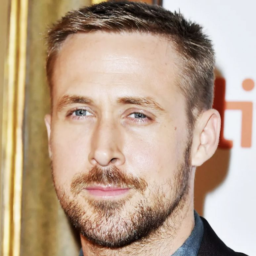

In [3]:
img = Image.open("/home/jovyan/novitskiy/AutoEnocders/generations/real_images/3.png")
img

In [4]:
scale = T.Lambda(
    lambda x: x * 2 - 1
)

inverse_scale = T.Lambda(
    lambda x: (x + 1) / 2
)


transform = T.Compose([
    ToTensor(),
    scale
])

inverse_transform = T.Compose([
    inverse_scale,
    T.Lambda(lambda x: x.permute(1, 2, 0))
])

In [5]:
down = DownScale()
jpeg = JPEGCompression(quality_range=[1, 100])
normal_noise = Noising()
blur = GaussinaBlur()
grayscale = Grayscale()

/home/jovyan/novitskiy/InstructFlow/instructflow/data/transforms.py:81: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.strengths = torch.range(


(tensor(-0.6879), tensor(0.9487))

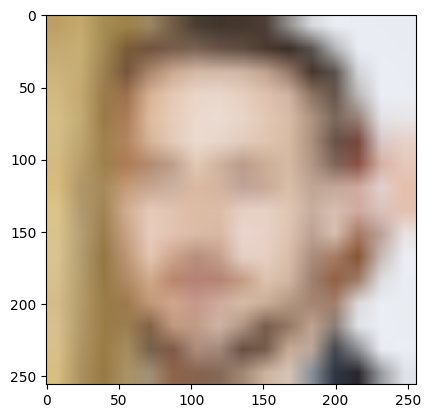

In [6]:
plt.imshow(inverse_transform(
    down(transform(img))[0]
))

down(transform(img))[0].min(), down(transform(img))[0].max()

(tensor(-1.), tensor(1.))

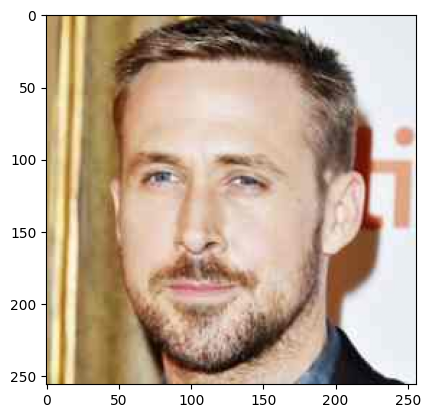

In [7]:
plt.imshow(inverse_transform(
    jpeg(transform(img))[0]
))

jpeg(transform(img))[0].min(), jpeg(transform(img))[0].max()

(tensor(-1.), tensor(1.))

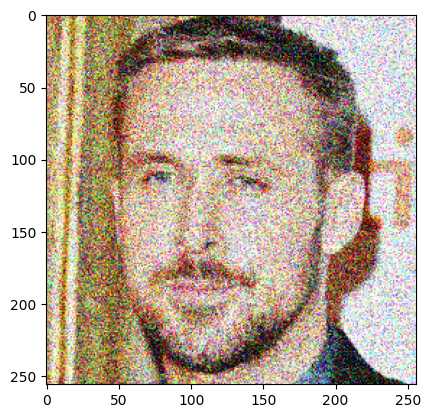

In [8]:
plt.imshow(inverse_transform(
    normal_noise(transform(img))[0]
))

normal_noise(transform(img))[0].min(), normal_noise(transform(img))[0].max()

(tensor(-0.9893), tensor(0.9511))

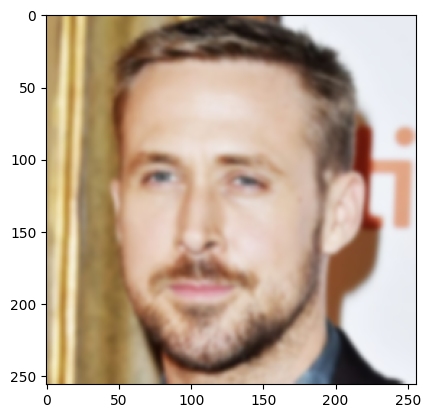

In [9]:
plt.imshow(inverse_transform(
    blur(transform(img))[0]
))

blur(transform(img))[0].min(), blur(transform(img))[0].max()

(tensor(-0.9837), tensor(0.9212))

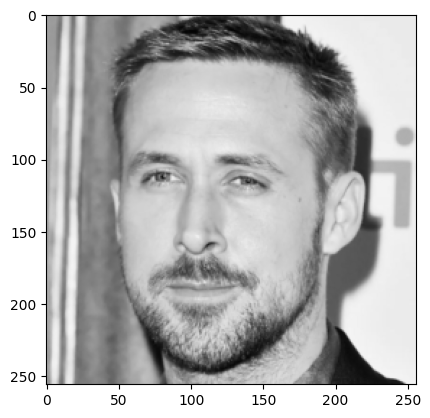

In [10]:
plt.imshow(inverse_transform(
    grayscale(transform(img))[0]
))

grayscale(transform(img))[0].min(), grayscale(transform(img))[0].max()

# Generating Images from Text

In [11]:
# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(config.model.model_id).to(config.trainer.device)

/home/jovyan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

# WandB

In [12]:
!wandb login --relogin 16e2a17c9f21df376f01b89f927dec88e33c2369

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


In [13]:
model_name = "SD 2.1 inverse tune fp32"

wandb.init(
    entity="leffff",
    project="InstructFlow",
    name=model_name,
    # resume=True
    # track hyperparameters and run metadata
    config={
        "architecture": "SD 2.1 U-Net",
        "base_model": config.model.model_id,
        "num_epochs": config.trainer.num_epochs,
        "learning_rate": config.trainer.learning_rate,
        "image_size": config.data.dataset.image_size,
        "batch_size": config.data.dataloader.batch_size
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leffff. Use `wandb login --relogin` to force relogin


# Dataset

In [14]:
import math

approx_num_samples, dataset = get_dataset(config.data)
approx_num_batches = math.ceil(approx_num_samples / config.data.dataloader.batch_size)

dataloader = DataLoader(
        dataset,
        batch_size=config.data.dataloader.batch_size,
        num_workers=config.data.dataloader.num_workers,
        pin_memory=True,
    )

!!! DATASET SIZE !!! 278964


/home/jovyan/novitskiy/InstructFlow/instructflow/data/transforms.py:81: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.strengths = torch.range(


In [15]:
x1, x0, ids, attn = next(iter(dataloader))

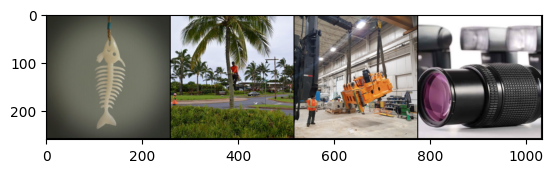

In [16]:
plt.imshow(show_images(x1[:4]))

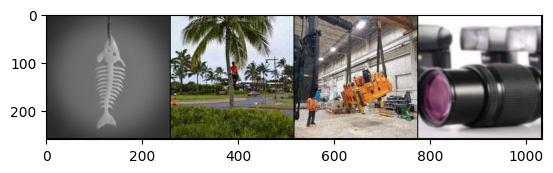

In [17]:
plt.imshow(show_images(x0[:4]))

# Train loop

In [18]:
import torch
from torch.nn import functional as F
from torch.distributions.normal import Normal


def flow_matching_loss(model, x_0, x_1, t, encoder_hidden_states):
    t = t.reshape((t.shape[0], 1, 1, 1))
    
    x_t = t * x_1 + (1 - t) * x_0
    t = t.flatten()

    noise_pred = unet(x_t, t, encoder_hidden_states=encoder_hidden_states).sample
    
    return F.mse_loss(noise_pred, (x_1 - x_0), reduction="mean")

In [19]:
def generate(unet, vae, x_0, encoder_hidden_states, n_steps: int = 100, device: str = "cuda"):
    unet.to(device)
    vae.to(device)
    unet.eval()
    vae.eval()
    
    x_t = x_0.to(device)

    bs = x_0.shape[0]
    
    eps = 1e-8
    t = torch.linspace(eps, 1 - eps, n_steps + 1).to(device)

    for i in range(1, len(t)):
        t_prev = t[i - 1].unsqueeze(0).repeat((bs,))

        with torch.no_grad():
            f_eval = unet(x_t, t_prev, encoder_hidden_states=encoder_hidden_states).sample
            
        x_t = x_t + (t[i] - t[i - 1]) * f_eval

    with torch.no_grad():
        x_t = vae.decode(x_t / 0.18215).sample
    
    return x_t


def generate_cfg(unet, vae, x_0, encoder_hidden_states, guidance_scale, n_steps: int = 100, device: str = "cuda"):
    unet.to(device)
    unet.eval()    

    x_t = x_0.to(device)

    bs = x_0.shape[0]
    
    eps = 1e-8
    t = torch.linspace(eps, 1 - eps, n_steps + 1).to(device)

    for i in range(1, len(t)):
        t_prev = t[i - 1].unsqueeze(0).repeat((bs,))

        with torch.no_grad():
            f_eval = unet(x_t, t_prev, encoder_hidden_states=encoder_hidden_states).sample
            
        x_t = x_t + (t[i] - t[i - 1]) * f_eval
    
    with torch.no_grad():
        x_t = vae.decode(x_t / 0.18215).sample
    
    return x_t

In [20]:
def train_epoch(unet, vae, text_encoder, dataloader, loss_function, optimizer, scheduler, device):
    unet.to(device)
    vae.to(device)
    text_encoder.to(device)
    
    unet.train()
    vae.eval()
    text_encoder.eval()

    total_loss = 0
    batch_i = 0
    for batch in tqdm(dataloader):
        x_1, x_0, input_ids, attention_mask = batch
        x_1, x_0, input_ids, attention_mask = x_1.to(device), x_0.to(device), input_ids.to(device), attention_mask.to(device)
        bs = x_1.shape[0]

        with torch.no_grad():
            x_1_latents = 0.18215 * vae.encode(x_1).latent_dist.mean
            x_0_latents = 0.18215 * vae.encode(x_0).latent_dist.mean

            encoder_hidden_states = text_encoder(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']

        t = torch.sigmoid(torch.randn((bs,), device=device))

        loss = loss_function(unet, x_0_latents, x_1_latents, t, encoder_hidden_states)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item() 
        batch_i += 1

        if batch_i % 5000 == 0:
            x_gen = generate(unet=unet, vae=vae, x_0=x_0_latents[:16], encoder_hidden_states=encoder_hidden_states[:16], device=device)
           
            log = {
                "loss": total_loss / 5000,
                "source_images": wandb.Image(show_images(x_0)),
                "generated_images": wandb.Image(show_images(x_gen)),
            }
            wandb.log(log)
            
            total_loss = 0

            torch.save(unet.state_dict(), f"/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/inverse_v1/{batch_i}.pt")

# Model

In [21]:
unet = pipe.unet.train()
vae = pipe.vae.eval()
text_encoder = pipe.text_encoder.eval()

last_checkpoint = os.listdir("checkpoints/sd_2_1_fm_generation_v1")[-1]
unet.load_state_dict(torch.load(f"checkpoints/sd_2_1_fm_generation_v1/{last_checkpoint}"))

optimizer = torch.optim.Adam(unet.parameters(), lr=config.trainer.learning_rate)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.trainer.lr_warmup_steps,
    num_training_steps=approx_num_batches * config.trainer.num_epochs
)

In [22]:
last_checkpoint

'595000.pt'

# Let's Train

In [ ]:
for i in range(config.trainer.num_epochs):
    train_epoch(
        unet=unet, 
        vae=vae, 
        text_encoder=text_encoder,
        dataloader=dataloader,
        loss_function=flow_matching_loss,
        optimizer=optimizer, 
        scheduler=scheduler, 
        device=config.trainer.device
    )

450it [09:57,  1.28s/it]/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/webdataset/handlers.py:33: UserWarning: KeyError('caption_clean')
  warnings.warn(repr(exn))
533it [11:43,  1.28s/it]/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/webdataset/handlers.py:33: UserWarning: KeyError('caption_clean')
  warnings.warn(repr(exn))
775it [16:52,  1.28s/it]/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/webdataset/handlers.py:33: UserWarning: KeyError('caption_clean')
  warnings.warn(repr(exn))
974it [21:07,  1.28s/it]/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/webdataset/handlers.py:33: UserWarning: KeyError('caption_clean')
  warnings.warn(repr(exn))
1170it [25:17,  1.28s/it]/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/webdataset/handlers.py:33: UserWarning: KeyError('caption_clean')
  warnings.warn(repr(exn))
1410it [30:24,  1.28s/it]/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/s